<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_2_3/a3_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number:

# Student 1:

# Student 2:

# Student 3:

# Downloading Data and Preliminaries

In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
from zipfile import ZipFile
import requests
import io

from torch import nn
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

In [2]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_pickle(zipfile, fn):
    return pickle.load(io.BytesIO(zipfile[fn]))

In [3]:
data = load_zip('https://surfdrive.surf.nl/files/index.php/s/cwqGaS22KXgnXtg/download')

    
"""
simulation_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_train = load_pickle(data, 'data/train/simulation.pickle')  # 3.1 + 3.2
simulation_valid = load_pickle(data, 'data/valid/simulation.pickle')  # 3.1 + 3.2
simulation_test = load_pickle(data, 'data/test/simulation.pickle')  # 3.1 + 3.2

"""
charges_{train, valid, test} is stored as a list of simulation-charges. 
These charges are stored as numpy arrays of size (3,): One value for each charge.
"""
charges_train = load_pickle(data, 'data/train/charges.pickle')  # 3.1
charges_valid = load_pickle(data, 'data/valid/charges.pickle')  # 3.1
charges_test = load_pickle(data, 'data/test/charges.pickle')  # 3.1

"""
simulation_continued_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_continued_train = load_pickle(data, 'data/train/simulation_continued.pickle')  # 3.2
simulation_continued_valid = load_pickle(data, 'data/valid/simulation_continued.pickle')  # 3.2
simulation_continued_test = load_pickle(data, 'data/test/simulation_continued.pickle')  # 3.2

"""
Note that the indices are shared throughout the different lists, e.g., for the 4th training simulation:
simulation_train[3] contains its initial simulation
charges_train[3] contains the charges associated with the simulation
simulation_continued_train[3] contains the continuation of the simulation 
                --> simulation_continued_train[3][0] is the state after simulation_train[3][-1]
"""
pass

In [4]:
print('Overview of no. datapoints:\n')

print('Task 3.1:')
print(f'{len(simulation_train)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(charges_train)} train, {len(charges_valid)} validation, {len(charges_test)} test charge pairs')
print()

print('Task 3.2:')
print('Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations')
print('We cut simulation_train down to the first 150 samples in simulation_train_task32')
simulation_train_task32 = simulation_train[:150]
print(f'{len(simulation_train_task32)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(simulation_continued_train)} train, {len(simulation_continued_valid)} validation, {len(simulation_continued_test)} test continuations')

print(f"""
For task 3.1, use:
{chr(10).join(["simulation_{} + charges_{}".format(t, t) for t in ["train", "valid", "test"]])}

For task 3.2, use:
{chr(10).join(["simulation_{} + simulation_continued_{}".format(*((t[0], t[1]) if isinstance(t, tuple) else (t, t))) for t in [("train_task32", "train"), "valid", "test"]])}
""")


Overview of no. datapoints:

Task 3.1:
800 train, 100 validation, 100 test simulations
800 train, 100 validation, 100 test charge pairs

Task 3.2:
Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations
We cut simulation_train down to the first 150 samples in simulation_train_task32
150 train, 100 validation, 100 test simulations
150 train, 100 validation, 100 test continuations

For task 3.1, use:
simulation_train + charges_train
simulation_valid + charges_valid
simulation_test + charges_test

For task 3.2, use:
simulation_train_task32 + simulation_continued_train
simulation_valid + simulation_continued_valid
simulation_test + simulation_continued_test



In [5]:
print('Print some shapes:\n')
for i in range(3):
    print('simulation_train[{}].shape:'.format(i), simulation_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('charges_train[{}].shape:'.format(i), charges_train[i].shape, '-> charges for the simulation')
    print('simulation_continued_train[{}].shape:'.format(i), simulation_continued_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('----\n')

Print some shapes:

simulation_train[0].shape: (103, 2) -> (t, 2), (x, y) at every t)
charges_train[0].shape: (3,) -> charges for the simulation
simulation_continued_train[0].shape: (54, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[1].shape: (97, 2) -> (t, 2), (x, y) at every t)
charges_train[1].shape: (3,) -> charges for the simulation
simulation_continued_train[1].shape: (45, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[2].shape: (99, 2) -> (t, 2), (x, y) at every t)
charges_train[2].shape: (3,) -> charges for the simulation
simulation_continued_train[2].shape: (47, 2) -> (t, 2), (x, y) at every t)
----



In [95]:
def plot_example(x, x_gt=None, x_pred=None, fn=None):
    charge_locations = np.array([[-1.53846154, -1.53846154],
                                 [ 1.53846154, -1.53846154],
                                 [ 0.        ,  1.53846154]])  # charge locations are fixed
    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    cmap = matplotlib.cm.get_cmap('tab20')
    plt.plot(x[:, 0], x[:, 1], color=cmap(0))
    plt.plot(x[0, 0], x[0, 1], 'd', color=cmap(1))
    fig.set_size_inches(5, 5)
    for charge in charge_locations:
        plt.plot(charge[0], charge[1], 'd', color='black')
    if x_gt is not None:
        plt.plot(x_gt[:, 0], x_gt[:, 1], color='red', linewidth=.5)
    if x_pred is not None:
        plt.plot(x_pred[:, 0], x_pred[:, 1], color='green', linestyle='--')
    if fn is None:
        plt.show()
    else:
        plt.savefig(fn)

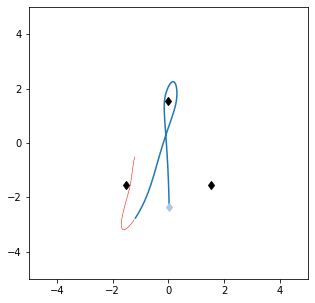

Charges are [-0.41459512 -0.36847363 -0.25877106]


In [96]:
test_idx = np.random.randint(150)
plot_example(simulation_train[test_idx], simulation_continued_train[test_idx])
print(f'Charges are {charges_train[test_idx]}')

# Task 3.1

## Data Handling and Preprocessing

In [8]:
#todo
#Playground
device = 'cuda:0'

In [9]:

from torch.utils.data import Dataset, DataLoader,TensorDataset
class DatasetTaskOne(Dataset):
    def __init__(self, simulation_data,charge_targets):
        padded_len = len(max(simulation_data, key=len)) # Should be 110 ideally but set to max length just in case
        padded_arrays = []
        for i in range(len(simulation_data)):
            diff = padded_len - simulation_data[i].shape[0] # How many rows should we pad?
            # Pad diff amount of [0,0] rows to the end 
            padded_arrays.append(np.pad(simulation_data[i],[(0,diff),(0,0)],mode='constant',constant_values=0))
        # Create data and target tensors
        data = np.array(padded_arrays)
        (samples,length,pos_dim) = data.shape
        self.data = torch.FloatTensor(data).view(samples,1,-1) # Samples,Channels,Sequence length
        print(self.data.shape)
        self.targets = torch.FloatTensor(np.array(charge_targets))
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        

        return x, y
    
    def __len__(self):
        return len(self.data)

In [10]:
t1_train_dataset = DatasetTaskOne(simulation_train,charges_train)
t1_train_loader = torch.utils.data.DataLoader(t1_train_dataset, batch_size=10)
t1_valid_dataset = DatasetTaskOne(simulation_valid,charges_valid)
t1_valid_loader = torch.utils.data.DataLoader(t1_valid_dataset, batch_size=10)
t1_test_dataset = DatasetTaskOne(simulation_test,charges_test)
t1_test_loader = torch.utils.data.DataLoader(t1_test_dataset, batch_size=10)

torch.Size([800, 1, 220])
torch.Size([100, 1, 220])
torch.Size([100, 1, 220])


## Model Implementation

In [11]:
#todo

In [12]:
class GRURegressor(nn.Module):

    def __init__(self, input_dim,hidden_dim,output_dim,device):
        super(GRURegressor, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.device = device
        
        # Compress sequence length into filters 
        self.rnn = nn.GRUCell(input_dim, hidden_dim)
        
        #self.drop = nn.Dropout(0.5)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, batch_input ):
        
        # input shapes:
        # batch_input: [batch_size, 1,seq_length]
            
        # Generate initial hidden and cell states
        hidden = torch.randn(batch_input.shape[0], self.hidden_dim).to(self.device) 
        
        # Feed packed input sequence to lstm 
        for i in range(0,220,2):
            hidden = self.rnn(batch_input[:,0,i:i+2],hidden) # Pass the i-th compressed sequence step
        # feed output to MLP, apply ReLU nonlinearity
        # shape [batch_size, hidden_dim]
        h = nn.ReLU()(self.fc1(hidden))
        output = self.fc2(h)
        return output

In [13]:
class ConvGRURegressor(nn.Module):

    def __init__(self, input_dim,hidden_dim,output_dim,device, conv_filters=64,kernel_size=4,stride=4):
        super(ConvGRURegressor, self).__init__()
        
        self.input_dim = input_dim
        self.conv_filters = conv_filters
        self.hidden_dim = hidden_dim
        self.device = device
        
        # Compress sequence length into filters 
        self.conv1d_1 = nn.Conv1d(1,out_channels=conv_filters,kernel_size=kernel_size,stride=stride,padding="valid")
        self.conv1d_2 = nn.Conv1d(conv_filters,out_channels=conv_filters*2,kernel_size=kernel_size,stride=stride,padding="valid")
        self.rnn = nn.GRUCell(conv_filters*2, hidden_dim)
        self.drop = nn.Dropout(0.5)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, batch_input ):
        
        # input shapes:
        # batch_input: [batch_size, 1,seq_length]
        embedding = self.conv1d_1(batch_input) # embedding: [batch_size,filters,reduced_sequence_length]
        embedding2 = self.conv1d_2(embedding) # embedding: [batch_size,filters,reduced_sequence_length]
            
        # Generate initial hidden and cell states
        hidden = torch.randn(batch_input.shape[0], self.hidden_dim).to(self.device) 
        
        # Feed packed input sequence to lstm 
        for i in range(embedding2.shape[2]):
            hidden = self.rnn(embedding2[:,:,i],hidden) # Pass the i-th compressed sequence step
        #hidden = self.drop(hidden)
        # feed output to MLP, apply ReLU nonlinearity
        # shape [batch_size, hidden_dim]
        h = nn.ReLU()(self.fc1(hidden))
        output = self.fc2(h)
        return output

In [14]:
class BenchmarkFNN(nn.Module):

    def __init__(self, input_dim,hidden_dim,output_dim,device):
        super(BenchmarkFNN, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.device = device
        
        self.drop = nn.Dropout(0.5)
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim//2)
        self.fc3 = nn.Linear(hidden_dim//2, output_dim)
    
    def forward(self, batch_input):
        
        # feed output to MLP, apply ReLU nonlinearity
        # shape [batch_size, hidden_dim]
        h1 = nn.ReLU()(self.fc1(batch_input))
        h1 = self.drop(h1)
        h2 = nn.ReLU()(self.fc2(h1))
        output = self.fc3(h2)
        return output

In [15]:
import time

## Model Training

In [16]:
#todo
def save_model_checkpoint(path, model, optimizer, val_loss, val_acc, train_acc, train_loss ):
    if path == None:
        return print("Kindly define a path")
    path = path
    
    save_dict = {"model_dict" : model.state_dict(), 
                 "optimizer_dict": optimizer.state_dict(),
                 "val_loss_dict": val_loss,
                 "val_acc_dict": val_acc,
                 "train_acc_dict": train_acc,
                 "train_loss_dict": train_loss}
    torch.save(save_dict, path)
    return print("Model Saved to ==> {}".format(path))

In [17]:
# training and validation after every epoch
def train(model, train_loader, val_loader, criterion, num_epochs, save_name):
    best_val_loss = float("Inf") 
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []
    cur_step = 0
    train_pred = []
    val_pred = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        running_train_acc = 0.0
  
        model.train()
        print("Starting epoch " + str(epoch+1))
        for train_data, targets in train_loader:
            
           
            # Forward
            input_tensor = train_data.to(device)
            outputs = model.forward(input_tensor)
            loss = criterion(outputs,targets.to(device))
            
                
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()   
            running_loss += loss
          

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print("Train Pass Completed")

        ########################################|Validation Set|#############################################
        val_running_loss = 0.0
        with torch.no_grad():
            model.eval()
            for val_data, val_targets in val_loader:
                input_tensor = val_data.to(device)
                outputs = model.forward(input_tensor)
                loss = criterion(outputs,val_targets.to(device))
                val_running_loss += loss

        avg_val_loss = val_running_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        
        print('Epoch [{}/{}],Train Loss: {:.4f}, Valid Loss: {:.8f}' 
            .format(epoch+1, num_epochs, avg_train_loss, avg_val_loss))
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss 
            save_model_checkpoint(save_name, model, optimizer, best_val_loss, 0, 0, avg_train_loss )
    
    print("Finished Training") 
    return train_losses, val_losses
     

In [ ]:
GRU_reg = GRURegressor(input_dim=2,hidden_dim=256,output_dim=3,device='cuda:0').cuda()

optimizer = torch.optim.SGD(GRU_reg.parameters(), lr=0.01, momentum=0.9)
#optimizer = torch.optim.Adam(GRU_reg.parameters(), lr= 1e-4, weight_decay = 0.01)
num_epochs = 400
save_name = f'GRU_reg.pt'
criterion = nn.MSELoss()
start_gru = time.time()
obtained_train_loss_gru, obtained_val_loss_gru = train(GRU_reg, 
                                                      t1_train_loader, t1_valid_loader, criterion, num_epochs, save_name)
end_gru = time.time()
print(f"Training took {end_gru - start_gru} seconds")

Starting epoch 1
Train Pass Completed
Epoch [1/400],Train Loss: 0.1180, Valid Loss: 0.09121832
Model Saved to ==> GRU_reg.pt
Starting epoch 2
Train Pass Completed
Epoch [2/400],Train Loss: 0.0827, Valid Loss: 0.09098180
Model Saved to ==> GRU_reg.pt
Starting epoch 3
Train Pass Completed
Epoch [3/400],Train Loss: 0.0825, Valid Loss: 0.09080890
Model Saved to ==> GRU_reg.pt
Starting epoch 4
Train Pass Completed
Epoch [4/400],Train Loss: 0.0823, Valid Loss: 0.09066916
Model Saved to ==> GRU_reg.pt
Starting epoch 5
Train Pass Completed
Epoch [5/400],Train Loss: 0.0822, Valid Loss: 0.09056342
Model Saved to ==> GRU_reg.pt
Starting epoch 6
Train Pass Completed
Epoch [6/400],Train Loss: 0.0821, Valid Loss: 0.09045406
Model Saved to ==> GRU_reg.pt
Starting epoch 7
Train Pass Completed
Epoch [7/400],Train Loss: 0.0820, Valid Loss: 0.09035828
Model Saved to ==> GRU_reg.pt
Starting epoch 8
Train Pass Completed
Epoch [8/400],Train Loss: 0.0819, Valid Loss: 0.09026947
Model Saved to ==> GRU_reg.pt


Train Pass Completed
Epoch [66/400],Train Loss: 0.0765, Valid Loss: 0.08618622
Model Saved to ==> GRU_reg.pt
Starting epoch 67
Train Pass Completed
Epoch [67/400],Train Loss: 0.0763, Valid Loss: 0.08614095
Model Saved to ==> GRU_reg.pt
Starting epoch 68
Train Pass Completed
Epoch [68/400],Train Loss: 0.0761, Valid Loss: 0.08601864
Model Saved to ==> GRU_reg.pt
Starting epoch 69
Train Pass Completed
Epoch [69/400],Train Loss: 0.0758, Valid Loss: 0.08587074
Model Saved to ==> GRU_reg.pt
Starting epoch 70
Train Pass Completed
Epoch [70/400],Train Loss: 0.0754, Valid Loss: 0.08565997
Model Saved to ==> GRU_reg.pt
Starting epoch 71
Train Pass Completed
Epoch [71/400],Train Loss: 0.0750, Valid Loss: 0.08526944
Model Saved to ==> GRU_reg.pt
Starting epoch 72
Train Pass Completed
Epoch [72/400],Train Loss: 0.0744, Valid Loss: 0.08448457
Model Saved to ==> GRU_reg.pt
Starting epoch 73
Train Pass Completed
Epoch [73/400],Train Loss: 0.0728, Valid Loss: 0.08243980
Model Saved to ==> GRU_reg.pt
St

Train Pass Completed
Epoch [141/400],Train Loss: 0.0464, Valid Loss: 0.04628314
Model Saved to ==> GRU_reg.pt
Starting epoch 142
Train Pass Completed
Epoch [142/400],Train Loss: 0.0445, Valid Loss: 0.04523191
Model Saved to ==> GRU_reg.pt
Starting epoch 143
Train Pass Completed
Epoch [143/400],Train Loss: 0.0440, Valid Loss: 0.04815779
Starting epoch 144
Train Pass Completed
Epoch [144/400],Train Loss: 0.0469, Valid Loss: 0.05127290
Starting epoch 145
Train Pass Completed
Epoch [145/400],Train Loss: 0.0456, Valid Loss: 0.04591759
Starting epoch 146
Train Pass Completed
Epoch [146/400],Train Loss: 0.0434, Valid Loss: 0.04445300
Model Saved to ==> GRU_reg.pt
Starting epoch 147
Train Pass Completed
Epoch [147/400],Train Loss: 0.0427, Valid Loss: 0.05647752
Starting epoch 148
Train Pass Completed
Epoch [148/400],Train Loss: 0.0438, Valid Loss: 0.05052811
Starting epoch 149
Train Pass Completed
Epoch [149/400],Train Loss: 0.0439, Valid Loss: 0.04636073
Starting epoch 150
Train Pass Complete

Train Pass Completed
Epoch [222/400],Train Loss: 0.0320, Valid Loss: 0.03900352
Starting epoch 223
Train Pass Completed
Epoch [223/400],Train Loss: 0.0315, Valid Loss: 0.04322088
Starting epoch 224
Train Pass Completed
Epoch [224/400],Train Loss: 0.0323, Valid Loss: 0.04089762
Starting epoch 225
Train Pass Completed
Epoch [225/400],Train Loss: 0.0327, Valid Loss: 0.03972773
Starting epoch 226
Train Pass Completed
Epoch [226/400],Train Loss: 0.0319, Valid Loss: 0.03603967
Model Saved to ==> GRU_reg.pt
Starting epoch 227
Train Pass Completed
Epoch [227/400],Train Loss: 0.0317, Valid Loss: 0.04146058
Starting epoch 228
Train Pass Completed
Epoch [228/400],Train Loss: 0.0315, Valid Loss: 0.03721813
Starting epoch 229
Train Pass Completed
Epoch [229/400],Train Loss: 0.0314, Valid Loss: 0.04129764
Starting epoch 230
Train Pass Completed
Epoch [230/400],Train Loss: 0.0306, Valid Loss: 0.03723794
Starting epoch 231
Train Pass Completed
Epoch [231/400],Train Loss: 0.0301, Valid Loss: 0.03914226

Train Pass Completed
Epoch [301/400],Train Loss: 0.0225, Valid Loss: 0.02982981
Starting epoch 302
Train Pass Completed
Epoch [302/400],Train Loss: 0.0221, Valid Loss: 0.03110049
Starting epoch 303
Train Pass Completed
Epoch [303/400],Train Loss: 0.0224, Valid Loss: 0.03116186
Starting epoch 304
Train Pass Completed
Epoch [304/400],Train Loss: 0.0223, Valid Loss: 0.02973814
Starting epoch 305
Train Pass Completed
Epoch [305/400],Train Loss: 0.0216, Valid Loss: 0.02887719
Starting epoch 306
Train Pass Completed
Epoch [306/400],Train Loss: 0.0226, Valid Loss: 0.03038402
Starting epoch 307
Train Pass Completed
Epoch [307/400],Train Loss: 0.0219, Valid Loss: 0.02897641
Starting epoch 308
Train Pass Completed
Epoch [308/400],Train Loss: 0.0219, Valid Loss: 0.02954028
Starting epoch 309
Train Pass Completed
Epoch [309/400],Train Loss: 0.0213, Valid Loss: 0.02985516
Starting epoch 310
Train Pass Completed
Epoch [310/400],Train Loss: 0.0221, Valid Loss: 0.03059273
Starting epoch 311
Train Pass

Train Pass Completed
Epoch [383/400],Train Loss: 0.0152, Valid Loss: 0.02723091
Starting epoch 384
Train Pass Completed
Epoch [384/400],Train Loss: 0.0155, Valid Loss: 0.02700138
Starting epoch 385
Train Pass Completed
Epoch [385/400],Train Loss: 0.0206, Valid Loss: 0.03015772
Starting epoch 386
Train Pass Completed
Epoch [386/400],Train Loss: 0.0194, Valid Loss: 0.02646951
Starting epoch 387
Train Pass Completed
Epoch [387/400],Train Loss: 0.0154, Valid Loss: 0.02663949
Starting epoch 388
Train Pass Completed
Epoch [388/400],Train Loss: 0.0152, Valid Loss: 0.02578042
Model Saved to ==> GRU_reg.pt
Starting epoch 389
Train Pass Completed
Epoch [389/400],Train Loss: 0.0146, Valid Loss: 0.02664649
Starting epoch 390
Train Pass Completed
Epoch [390/400],Train Loss: 0.0144, Valid Loss: 0.02613761
Starting epoch 391
Train Pass Completed
Epoch [391/400],Train Loss: 0.0144, Valid Loss: 0.02632868
Starting epoch 392
Train Pass Completed
Epoch [392/400],Train Loss: 0.0145, Valid Loss: 0.02627890

In [ ]:
conv_GRU_reg = ConvGRURegressor(input_dim=220,hidden_dim=256,output_dim=3,device='cuda:0').cuda()

optimizer = torch.optim.SGD(conv_GRU_reg.parameters(), lr=0.01, momentum=0.9)
#optimizer = torch.optim.Adam(conv_GRU_reg.parameters(), lr= 6e-4, weight_decay = 0.01)
num_epochs = 400
save_name = f'conv_GRU_reg_trial2.pt'
criterion = nn.MSELoss()

start_conv_gru = time.time()
obtained_train_loss_conv_gru, obtained_val_loss_conv_gru = train(conv_GRU_reg, 
                                                      t1_train_loader, t1_valid_loader, criterion, num_epochs, save_name)
end_conv_gru = time.time()
print(f"Training took {end_conv_gru - start_conv_gru} seconds!")

Starting epoch 1
Train Pass Completed
Epoch [1/400],Train Loss: 0.1016, Valid Loss: 0.07059129
Model Saved to ==> conv_GRU_reg_trial2.pt
Starting epoch 2
Train Pass Completed
Epoch [2/400],Train Loss: 0.0599, Valid Loss: 0.06302142
Model Saved to ==> conv_GRU_reg_trial2.pt
Starting epoch 3
Train Pass Completed
Epoch [3/400],Train Loss: 0.0541, Valid Loss: 0.05880982
Model Saved to ==> conv_GRU_reg_trial2.pt
Starting epoch 4
Train Pass Completed
Epoch [4/400],Train Loss: 0.0508, Valid Loss: 0.05574536
Model Saved to ==> conv_GRU_reg_trial2.pt
Starting epoch 5
Train Pass Completed
Epoch [5/400],Train Loss: 0.0484, Valid Loss: 0.05309771
Model Saved to ==> conv_GRU_reg_trial2.pt
Starting epoch 6
Train Pass Completed
Epoch [6/400],Train Loss: 0.0464, Valid Loss: 0.05088134
Model Saved to ==> conv_GRU_reg_trial2.pt
Starting epoch 7
Train Pass Completed
Epoch [7/400],Train Loss: 0.0445, Valid Loss: 0.04848728
Model Saved to ==> conv_GRU_reg_trial2.pt
Starting epoch 8
Train Pass Completed
Epo

Train Pass Completed
Epoch [66/400],Train Loss: 0.0093, Valid Loss: 0.01278267
Model Saved to ==> conv_GRU_reg_trial2.pt
Starting epoch 67
Train Pass Completed
Epoch [67/400],Train Loss: 0.0092, Valid Loss: 0.01274130
Model Saved to ==> conv_GRU_reg_trial2.pt
Starting epoch 68
Train Pass Completed
Epoch [68/400],Train Loss: 0.0091, Valid Loss: 0.01275819
Starting epoch 69
Train Pass Completed
Epoch [69/400],Train Loss: 0.0090, Valid Loss: 0.01236827
Model Saved to ==> conv_GRU_reg_trial2.pt
Starting epoch 70
Train Pass Completed
Epoch [70/400],Train Loss: 0.0089, Valid Loss: 0.01261721
Starting epoch 71
Train Pass Completed
Epoch [71/400],Train Loss: 0.0084, Valid Loss: 0.01222365
Model Saved to ==> conv_GRU_reg_trial2.pt
Starting epoch 72
Train Pass Completed
Epoch [72/400],Train Loss: 0.0086, Valid Loss: 0.01270974
Starting epoch 73
Train Pass Completed
Epoch [73/400],Train Loss: 0.0082, Valid Loss: 0.01278130
Starting epoch 74
Train Pass Completed
Epoch [74/400],Train Loss: 0.0080, 

Train Pass Completed
Epoch [143/400],Train Loss: 0.0035, Valid Loss: 0.00907075
Starting epoch 144
Train Pass Completed
Epoch [144/400],Train Loss: 0.0033, Valid Loss: 0.00886410
Starting epoch 145
Train Pass Completed
Epoch [145/400],Train Loss: 0.0034, Valid Loss: 0.00891322
Starting epoch 146
Train Pass Completed
Epoch [146/400],Train Loss: 0.0034, Valid Loss: 0.00911234
Starting epoch 147
Train Pass Completed
Epoch [147/400],Train Loss: 0.0033, Valid Loss: 0.00995799
Starting epoch 148
Train Pass Completed
Epoch [148/400],Train Loss: 0.0033, Valid Loss: 0.00904470
Starting epoch 149
Train Pass Completed
Epoch [149/400],Train Loss: 0.0032, Valid Loss: 0.00940997
Starting epoch 150
Train Pass Completed
Epoch [150/400],Train Loss: 0.0032, Valid Loss: 0.00966043
Starting epoch 151
Train Pass Completed
Epoch [151/400],Train Loss: 0.0033, Valid Loss: 0.00933245
Starting epoch 152
Train Pass Completed
Epoch [152/400],Train Loss: 0.0033, Valid Loss: 0.00933564
Starting epoch 153
Train Pass

Train Pass Completed
Epoch [225/400],Train Loss: 0.0022, Valid Loss: 0.00880147
Starting epoch 226
Train Pass Completed
Epoch [226/400],Train Loss: 0.0023, Valid Loss: 0.00896777
Starting epoch 227
Train Pass Completed
Epoch [227/400],Train Loss: 0.0022, Valid Loss: 0.00893209
Starting epoch 228
Train Pass Completed
Epoch [228/400],Train Loss: 0.0022, Valid Loss: 0.00884341
Starting epoch 229
Train Pass Completed
Epoch [229/400],Train Loss: 0.0022, Valid Loss: 0.00893160
Starting epoch 230
Train Pass Completed
Epoch [230/400],Train Loss: 0.0024, Valid Loss: 0.00922553
Starting epoch 231
Train Pass Completed
Epoch [231/400],Train Loss: 0.0022, Valid Loss: 0.00904068
Starting epoch 232
Train Pass Completed
Epoch [232/400],Train Loss: 0.0022, Valid Loss: 0.00894326
Starting epoch 233
Train Pass Completed
Epoch [233/400],Train Loss: 0.0023, Valid Loss: 0.00906347
Starting epoch 234
Train Pass Completed
Epoch [234/400],Train Loss: 0.0023, Valid Loss: 0.00970257
Starting epoch 235
Train Pass

Train Pass Completed
Epoch [304/400],Train Loss: 0.0011, Valid Loss: 0.00718364
Starting epoch 305
Train Pass Completed
Epoch [305/400],Train Loss: 0.0011, Valid Loss: 0.00756789
Starting epoch 306
Train Pass Completed
Epoch [306/400],Train Loss: 0.0011, Valid Loss: 0.00762198
Starting epoch 307
Train Pass Completed
Epoch [307/400],Train Loss: 0.0011, Valid Loss: 0.00749943
Starting epoch 308
Train Pass Completed
Epoch [308/400],Train Loss: 0.0010, Valid Loss: 0.00777198
Starting epoch 309
Train Pass Completed
Epoch [309/400],Train Loss: 0.0011, Valid Loss: 0.00752852
Starting epoch 310
Train Pass Completed
Epoch [310/400],Train Loss: 0.0011, Valid Loss: 0.00732969
Starting epoch 311
Train Pass Completed
Epoch [311/400],Train Loss: 0.0011, Valid Loss: 0.00748170
Starting epoch 312
Train Pass Completed
Epoch [312/400],Train Loss: 0.0010, Valid Loss: 0.00796031
Starting epoch 313
Train Pass Completed
Epoch [313/400],Train Loss: 0.0010, Valid Loss: 0.00775390
Starting epoch 314
Train Pass

Train Pass Completed
Epoch [387/400],Train Loss: 0.0009, Valid Loss: 0.00739346
Starting epoch 388
Train Pass Completed
Epoch [388/400],Train Loss: 0.0008, Valid Loss: 0.00732522
Starting epoch 389
Train Pass Completed
Epoch [389/400],Train Loss: 0.0009, Valid Loss: 0.00747068
Starting epoch 390
Train Pass Completed
Epoch [390/400],Train Loss: 0.0008, Valid Loss: 0.00729423
Starting epoch 391
Train Pass Completed
Epoch [391/400],Train Loss: 0.0008, Valid Loss: 0.00735707
Starting epoch 392
Train Pass Completed
Epoch [392/400],Train Loss: 0.0009, Valid Loss: 0.00756856
Starting epoch 393
Train Pass Completed
Epoch [393/400],Train Loss: 0.0009, Valid Loss: 0.00762154
Starting epoch 394
Train Pass Completed
Epoch [394/400],Train Loss: 0.0008, Valid Loss: 0.00767929
Starting epoch 395
Train Pass Completed
Epoch [395/400],Train Loss: 0.0009, Valid Loss: 0.00776671
Starting epoch 396
Train Pass Completed
Epoch [396/400],Train Loss: 0.0008, Valid Loss: 0.00734333
Starting epoch 397
Train Pass

In [ ]:
# Benchmark Neural Network. Play around with hidden dim.
benchmark_fnn = BenchmarkFNN(input_dim=220,hidden_dim=256,output_dim=3,device='cuda:0').cuda()

optimizer = torch.optim.SGD(benchmark_fnn.parameters(), lr=0.01, momentum=0.9)
#optimizer = torch.optim.Adam(benchmark_fnn.parameters(), lr= 6e-4, weight_decay = 0.01)
num_epochs = 400
save_name = f'benchmark_fnn.pt'
criterion = nn.MSELoss()

start_fnn = time.time()
obtained_train_loss_fnn, obtained_val_loss_fnn = train(benchmark_fnn, 
                                                      t1_train_loader, t1_valid_loader, criterion, num_epochs, save_name)
end_fnn = time.time()
print(f"Training took {end_fnn - start_fnn} seconds!")

Starting epoch 1


/home/lostarious/anaconda3/envs/ml/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([10, 3])) that is different to the input size (torch.Size([10, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Train Pass Completed
Epoch [1/400],Train Loss: 0.1235, Valid Loss: 0.11318190
Model Saved to ==> benchmark_fnn.pt
Starting epoch 2
Train Pass Completed
Epoch [2/400],Train Loss: 0.0891, Valid Loss: 0.09980021
Model Saved to ==> benchmark_fnn.pt
Starting epoch 3
Train Pass Completed
Epoch [3/400],Train Loss: 0.0860, Valid Loss: 0.09831776
Model Saved to ==> benchmark_fnn.pt
Starting epoch 4
Train Pass Completed
Epoch [4/400],Train Loss: 0.0847, Valid Loss: 0.09747037
Model Saved to ==> benchmark_fnn.pt
Starting epoch 5
Train Pass Completed
Epoch [5/400],Train Loss: 0.0839, Valid Loss: 0.09634664
Model Saved to ==> benchmark_fnn.pt
Starting epoch 6
Train Pass Completed
Epoch [6/400],Train Loss: 0.0836, Valid Loss: 0.09588137
Model Saved to ==> benchmark_fnn.pt
Starting epoch 7
Train Pass Completed
Epoch [7/400],Train Loss: 0.0831, Valid Loss: 0.09511092
Model Saved to ==> benchmark_fnn.pt
Starting epoch 8
Train Pass Completed
Epoch [8/400],Train Loss: 0.0829, Valid Loss: 0.09455439
Model

Train Pass Completed
Epoch [77/400],Train Loss: 0.0815, Valid Loss: 0.09162148
Starting epoch 78
Train Pass Completed
Epoch [78/400],Train Loss: 0.0814, Valid Loss: 0.09145274
Starting epoch 79
Train Pass Completed
Epoch [79/400],Train Loss: 0.0813, Valid Loss: 0.09144800
Starting epoch 80
Train Pass Completed
Epoch [80/400],Train Loss: 0.0816, Valid Loss: 0.09152862
Starting epoch 81
Train Pass Completed
Epoch [81/400],Train Loss: 0.0815, Valid Loss: 0.09150635
Starting epoch 82
Train Pass Completed
Epoch [82/400],Train Loss: 0.0814, Valid Loss: 0.09155493
Starting epoch 83
Train Pass Completed
Epoch [83/400],Train Loss: 0.0814, Valid Loss: 0.09159499
Starting epoch 84
Train Pass Completed
Epoch [84/400],Train Loss: 0.0814, Valid Loss: 0.09158716
Starting epoch 85
Train Pass Completed
Epoch [85/400],Train Loss: 0.0813, Valid Loss: 0.09165546
Starting epoch 86
Train Pass Completed
Epoch [86/400],Train Loss: 0.0812, Valid Loss: 0.09160607
Starting epoch 87
Train Pass Completed
Epoch [87

Epoch [160/400],Train Loss: 0.0811, Valid Loss: 0.09165977
Starting epoch 161
Train Pass Completed
Epoch [161/400],Train Loss: 0.0810, Valid Loss: 0.09153388
Starting epoch 162
Train Pass Completed
Epoch [162/400],Train Loss: 0.0810, Valid Loss: 0.09129021
Starting epoch 163
Train Pass Completed
Epoch [163/400],Train Loss: 0.0811, Valid Loss: 0.09149405
Starting epoch 164
Train Pass Completed
Epoch [164/400],Train Loss: 0.0809, Valid Loss: 0.09163773
Starting epoch 165
Train Pass Completed
Epoch [165/400],Train Loss: 0.0810, Valid Loss: 0.09125329
Starting epoch 166
Train Pass Completed
Epoch [166/400],Train Loss: 0.0809, Valid Loss: 0.09126800
Starting epoch 167
Train Pass Completed
Epoch [167/400],Train Loss: 0.0810, Valid Loss: 0.09125897
Starting epoch 168
Train Pass Completed
Epoch [168/400],Train Loss: 0.0811, Valid Loss: 0.09123640
Starting epoch 169
Train Pass Completed
Epoch [169/400],Train Loss: 0.0808, Valid Loss: 0.09135383
Starting epoch 170
Train Pass Completed
Epoch [170

Train Pass Completed
Epoch [243/400],Train Loss: 0.0807, Valid Loss: 0.09147384
Starting epoch 244
Train Pass Completed
Epoch [244/400],Train Loss: 0.0806, Valid Loss: 0.09143499
Starting epoch 245
Train Pass Completed
Epoch [245/400],Train Loss: 0.0808, Valid Loss: 0.09133565
Starting epoch 246
Train Pass Completed
Epoch [246/400],Train Loss: 0.0808, Valid Loss: 0.09149136
Starting epoch 247
Train Pass Completed
Epoch [247/400],Train Loss: 0.0806, Valid Loss: 0.09155382
Starting epoch 248
Train Pass Completed
Epoch [248/400],Train Loss: 0.0807, Valid Loss: 0.09149410
Starting epoch 249
Train Pass Completed
Epoch [249/400],Train Loss: 0.0805, Valid Loss: 0.09148847
Starting epoch 250
Train Pass Completed
Epoch [250/400],Train Loss: 0.0806, Valid Loss: 0.09150782
Starting epoch 251
Train Pass Completed
Epoch [251/400],Train Loss: 0.0806, Valid Loss: 0.09169681
Starting epoch 252
Train Pass Completed
Epoch [252/400],Train Loss: 0.0807, Valid Loss: 0.09145994
Starting epoch 253
Train Pass

Train Pass Completed
Epoch [326/400],Train Loss: 0.0802, Valid Loss: 0.09182086
Starting epoch 327
Train Pass Completed
Epoch [327/400],Train Loss: 0.0802, Valid Loss: 0.09186443
Starting epoch 328
Train Pass Completed
Epoch [328/400],Train Loss: 0.0801, Valid Loss: 0.09166139
Starting epoch 329
Train Pass Completed
Epoch [329/400],Train Loss: 0.0803, Valid Loss: 0.09185328
Starting epoch 330
Train Pass Completed
Epoch [330/400],Train Loss: 0.0802, Valid Loss: 0.09168839
Starting epoch 331
Train Pass Completed
Epoch [331/400],Train Loss: 0.0801, Valid Loss: 0.09156994
Starting epoch 332
Train Pass Completed
Epoch [332/400],Train Loss: 0.0802, Valid Loss: 0.09185506
Starting epoch 333
Train Pass Completed
Epoch [333/400],Train Loss: 0.0802, Valid Loss: 0.09167274
Starting epoch 334
Train Pass Completed
Epoch [334/400],Train Loss: 0.0802, Valid Loss: 0.09174346
Starting epoch 335
Train Pass Completed
Epoch [335/400],Train Loss: 0.0800, Valid Loss: 0.09176715
Starting epoch 336
Train Pass

## Evaluation

In [55]:
#todo
def create_loss_plot(obtained_train_loss,obtained_val_loss,model_name,num_epochs,log_scale=True):
    converted_train_loss = [tensor.detach().item() for tensor in obtained_train_loss]
    converted_val_loss = [tensor.detach().item() for tensor in obtained_val_loss]
    fig = plt.gcf()
    fig.set_size_inches(9.5, 3.5)
    plt.plot(range(0,num_epochs),converted_train_loss, label = "Training Loss", color = "blue")
    plt.plot(range(0,num_epochs),converted_val_loss, label = "Validation Loss", color = "red")
    plt.title('Loss Vs Epochs', fontsize=14)
    plt.xlabel('#Epochs', fontsize=14)
    plt.grid(True)
    plt.legend()
    scale = ""
    if log_scale:
        scale = '_log'
        plt.yscale("log")
        plt.ylabel('Loss (Log scale)', fontsize=14)
    else:
        plt.ylabel('Loss', fontsize=14)
    
    plt.show()
    fig.savefig(f'{model_name}_{num_epochs}{scale}.png')
    fig = plt.gcf()

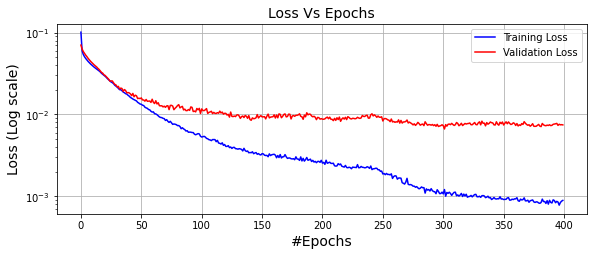

<Figure size 432x288 with 0 Axes>

In [ ]:
create_loss_plot(obtained_train_loss_conv_gru,obtained_val_loss_conv_gru,'conv_gru',num_epochs=num_epochs,log_scale=True)

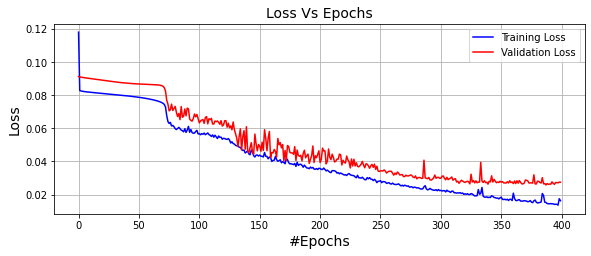

<Figure size 432x288 with 0 Axes>

In [ ]:
create_loss_plot(obtained_train_loss_gru,obtained_val_loss_gru,'gru',num_epochs=num_epochs,log_scale=False)

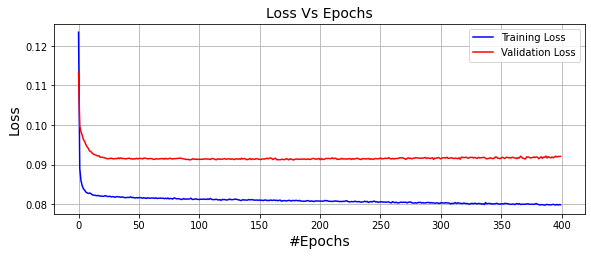

<Figure size 432x288 with 0 Axes>

In [ ]:
create_loss_plot(obtained_train_loss_fnn,obtained_val_loss_fnn,'fnn',num_epochs=num_epochs,log_scale=False)

In [ ]:
#Best val losses
print(f"Best Val loss (ConvGRURegressor): {min(obtained_val_loss_conv_gru)}")
print(f"Best Val loss (GRURegressor): {min(obtained_val_loss_gru)}")
print(f"Best Val loss (BenchmarkFNN): {min(obtained_val_loss_fnn)}")

Best Val loss (ConvGRURegressor): 0.006631342228502035
Best Val loss (GRURegressor): 0.02578042447566986
Best Val loss (BenchmarkFNN): 0.09115961939096451


In [59]:
def evaluate(model, test_loader,device='cpu'):
    val_running_loss = 0.0
    preds = []
    actual = []
    with torch.no_grad():
        model.eval()
        for val_data, val_targets in test_loader:
            input_tensor = val_data.to(device)
            outputs = model.forward(input_tensor)
            preds.append(outputs)
            actual.append(val_targets)
            loss = criterion(outputs,val_targets.to(device))
            val_running_loss += loss

        avg_val_loss = val_running_loss / len(test_loader)
        print("Average Test Loss: {:4f}".format(avg_val_loss))
        return preds,actual

In [ ]:
#Model Evaluation
#ConvGRURegressor
model = ConvGRURegressor(input_dim=220,hidden_dim=256,output_dim=3,device='cpu')
checkpoint = torch.load('conv_GRU_reg_trial2.pt', map_location = 'cpu')
model.load_state_dict(checkpoint['model_dict'])

preds,actual = evaluate(model, t1_test_loader)

Average Test Loss: 0.008653


In [ ]:
#Model Evaluation
#GRURegressor
model = GRURegressor(input_dim=2,hidden_dim=256,output_dim=3,device='cpu')
checkpoint = torch.load('GRU_reg.pt', map_location = 'cpu')
model.load_state_dict(checkpoint['model_dict'])

preds,actual = evaluate(model, t1_test_loader)

Average Test Loss: 0.024429


In [ ]:
#Model Evaluation
#BenchmarkFNN
model = BenchmarkFNN(input_dim=220,hidden_dim=256,output_dim=3,device='cuda:0')
checkpoint = torch.load('benchmark_fnn.pt', map_location = 'cpu')
model.load_state_dict(checkpoint['model_dict'])

preds,actual = evaluate(model, t1_test_loader)

Average Test Loss: 0.084892


# Task 3.2

## Data Handling and Preprocessing

In [18]:
#todo

In [19]:
#Task 3.2

from torch.utils.data import Dataset, DataLoader,TensorDataset
class DatasetTaskTwo(Dataset):
    def __init__(self, simulation_data,continued_simulations):
        padded_len = len(max(simulation_data, key=len)) # Should be 110 ideally but set to max length just in case
        padded_arrays = []
        for i in range(len(simulation_data)):
            diff = padded_len - simulation_data[i].shape[0] # How many rows should we pad?
            # Pad diff amount of [0,0] rows to the end 
            padded_arrays.append(np.pad(simulation_data[i],[(0,diff),(0,0)],mode='constant',constant_values= 0))
            for tr_simulations in range(len(padded_arrays)):#remove the 0 padding and replace with the last two co-ordinates
                for tr_arr in range(len(padded_arrays[tr_simulations])):
                    if padded_arrays[tr_simulations][tr_arr][0] == float(0) and padded_arrays[tr_simulations][tr_arr][1] == float(0):
                        padded_arrays[tr_simulations][tr_arr][0] = padded_arrays[tr_simulations][tr_arr-1][0]
                        padded_arrays[tr_simulations][tr_arr][1] = padded_arrays[tr_simulations][tr_arr-1][1]
                   
        # Create data and target tensors
        data = np.array(padded_arrays)
        (samples,length,pos_dim) = data.shape
        self.data = torch.FloatTensor(data).view(samples,1,-1) # Samples,Channels,Sequence length
        print(len(self.data))
        print(self.data.shape)
        
        
        padded_len_target = 60#len(max(continued_simulations, key = len))
        padded_target_array = []
        for j in range(len(continued_simulations)):
            diff_targ = padded_len_target - continued_simulations[j].shape[0]
            padded_target_array.append(np.pad(continued_simulations[j], [(0, diff_targ), (0,0)], mode = 'constant', constant_values = 0))
            for simulations in range(len(padded_target_array)): #remove the 0 padding and replace with the last two co-ordinates
                for arr in range(len(padded_target_array[simulations])):
                    if padded_target_array[simulations][arr][0] == float(0) and padded_target_array[simulations][arr][1] == float(0):
                        padded_target_array[simulations][arr][0] = padded_target_array[simulations][arr-1][0]
                        padded_target_array[simulations][arr][1] = padded_target_array[simulations][arr-1][1]
        
        
        print(padded_target_array[0].shape)
        targets = np.array(padded_target_array)
        
        (targ_samples, targ_length, targ_pos_dim) = targets.shape
        self.targets = torch.FloatTensor(targets).view(targ_samples,1,-1)
        print(self.targets.shape)
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        

        return x, y
    
    def __len__(self):
        return len(self.data)

In [20]:

t2_train_dataset = DatasetTaskTwo(simulation_train_task32,simulation_continued_train)
t2_train_loader = torch.utils.data.DataLoader(t2_train_dataset, batch_size=10)
t2_valid_dataset = DatasetTaskTwo(simulation_valid,simulation_continued_valid)
t2_valid_loader = torch.utils.data.DataLoader(t2_valid_dataset, batch_size=10)
t2_test_dataset = DatasetTaskTwo(simulation_test,simulation_continued_test)
t2_test_loader = torch.utils.data.DataLoader(t2_test_dataset, batch_size=10)

150
torch.Size([150, 1, 220])
(60, 2)
torch.Size([150, 1, 120])
100
torch.Size([100, 1, 220])
(60, 2)
torch.Size([100, 1, 120])
100
torch.Size([100, 1, 220])
(60, 2)
torch.Size([100, 1, 120])


## Model Implementation

In [21]:
#todo
import torch.nn.functional as F

In [22]:
class ConvGRUForecaster(nn.Module):

    def __init__(self, input_dim,hidden_dim,output_dim,device, 
                 dropout_rate=0.2,seq_length=110,forecast_length=60,
                 conv_filters=128,kernel_size=4,stride=4):
        super(ConvGRUForecaster, self).__init__()
        
        self.input_dim = input_dim
        self.conv_filters = conv_filters
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.device = device
        self.forecast_length = forecast_length
        self.dropout = nn.Dropout(dropout_rate)
        # Compress sequence length into filters 
        self.conv1d_1 = nn.Conv1d(1,out_channels=conv_filters,kernel_size=kernel_size,stride=stride,padding="valid")
        self.conv1d_2 = nn.Conv1d(conv_filters,out_channels=conv_filters*2,kernel_size=kernel_size,stride=stride,padding="valid")
        
        self.encoder = nn.GRUCell(conv_filters*2, hidden_dim)
        self.decoder = nn.GRUCell(output_dim,hidden_dim)
        
        
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, batch_input ):
        
        # input shapes:
        # batch_input: [batch_size, 1,seq_length]
        embedding = self.conv1d_1(batch_input) # embedding: [batch_size,filters,reduced_sequence_length]
        embedding2 = self.conv1d_2(embedding) # embedding: [batch_size,filters,reduced_sequence_length]
            
        # Generate initial hidden and cell states
        hidden = torch.randn(batch_input.shape[0], self.hidden_dim).to(self.device) 
        
        # Feed packed input sequence to lstm 
        for i in range(embedding2.shape[2]):
            hidden = self.encoder(embedding2[:,:,i],hidden) # Pass the i-th compressed sequence step
        #hidden = self.dropout(hidden)
        
        output = batch_input[:,0,-2:].clone().detach().to(self.device) # copy the last known position of the particle
        outputs = []
        for i in range(self.forecast_length):
            hidden = self.decoder(output,hidden)
            h = nn.ReLU()(self.dropout(self.fc1(hidden)))
            output = self.fc2(self.dropout(h))
            outputs.append(output)
        
        return torch.stack(outputs,axis=1).view(batch_input.shape[0],-1) #[batch_size (10), seq_len*pos_dim (120)]

In [23]:
# We will create a seq2seq encoder decoder model with LSTM's

#Encoder model with a gated recurrent unit
class LSTMEncoder(nn.Module):
  def __init__(self, input_dim,hidden_dim,output_dim,device, conv_filters=64,kernel_size=4,stride=4):
    super(LSTMEncoder, self).__init__()
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.device = device
    self.conv_filters = conv_filters
    self.kernel_size = kernel_size
    self.stride = stride

    self.rnn = nn.LSTMCell(input_dim, hidden_dim)
    self.drop = nn.Dropout(0.5)
    self.fc1 = nn.Linear(hidden_dim, hidden_dim)
    self.fc2 = nn.Linear(hidden_dim, output_dim)
    self.conv1d_1 = nn.Conv1d(1,out_channels=conv_filters,kernel_size=kernel_size,stride=stride,padding="valid")
    self.conv1d_2 = nn.Conv1d(conv_filters,out_channels=conv_filters*2,kernel_size=kernel_size,stride=stride,padding="valid")


  def forward(self, batch_input):

    embedding1 = self.conv1d_1(batch_input)
    embedding2 = self.conv1d_2(embedding1)

    hidden0 = torch.randn(batch_input.shape[0], self.hidden_dim).to(self.device)
    c0 = torch.randn(batch_input.shape[0], self.hidden_dim).to(self.device)




    for i in range(embedding2.shape[2]):
            hidden, ct = self.rnn(embedding2[:,:,i],(hidden0, c0))



    h = nn.ReLU()(self.fc1(hidden))
    c = nn.ReLU()(self.fc1(ct))
    hidden_output = self.fc2(h)
    cell_state_output = self.fc2(c)

    return hidden_output, cell_state_output


# We will create a Decoder Model

# Gated Decoder that creates a sequence 
# We will try to give it the hidden state as well as the time sequence (seq_len - 1)
class LSTMDecoder(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, device):
    super(LSTMDecoder, self).__init__()


    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.device  = device
    self.output_dim = output_dim
 


    self.rnn = nn.LSTMCell(input_dim, hidden_dim)

    self.drop = nn.Dropout(0.5)
    self.fc1 = nn.Linear(hidden_dim, hidden_dim)
    self.fc2 = nn.Linear(hidden_dim, output_dim)
    

  def forward(self, batch_input, hidden0, c0):
    hidden_state_vectors = []
    cell_state_vectors = []
    output_vectors = []
    self.hidden0 = hidden0
    self.c0 = c0

    for i in range(0,60):
      hidden, ct = self.rnn(batch_input[:,0,-2:],(hidden0, c0))#.to(self.device)
      #hidden, ct = self.rnn(batch_input[:,0,i:i+2],(hidden0, c0))#.to(self.device)
      hidden_state_vectors.append(hidden)
      cell_state_vectors.append(ct)
    
    for op in range(len(hidden_state_vectors)):
          h1 = nn.ReLU()(self.fc1(hidden_state_vectors[op]))
          ctx = nn.ReLU()(self.fc1(cell_state_vectors[op]))
          comb_states = torch.add(h1, ctx)
          mean_comb = torch.div(comb_states, 2)
          #print(comb_states.shape)
          # print(ctx.shape)
          h2 = self.fc2(mean_comb) #operation [10,256] and [256,2]
          #h2 has a dimension (10, 2)
          #h2 batch =1 has the shape (1,2) and we have 60 time steps.
            

          output_vectors.append(h2)
      
    outputs = torch.stack(output_vectors, dim=1)
    #print(outputs.shape)
        
    final_output = []
    op = outputs.reshape(10,120)
    opf = torch.unsqueeze(op,0)
    opf = opf.reshape(10,1,120)
    # for tens in range(len(outputs)):
    #   t = outputs[tens].view(1,-1) #we need the output as [10,1,120], it was [10,60,20]. Hence the conversion
    #   final_output.append(t)
        
    # model_output = torch.cat(final_output)
            
    return opf


class seq2seq(nn.Module):
  def __init__(self, encoder, decoder, device):
    super(seq2seq, self).__init__()

    self.encoder = encoder
    self.decoder = decoder
    self.device = device
  
  def forward(self, batch_input1, batch_input2):

    self.batch_input1 = batch_input1
    self.batch_input2 = batch_input2

    context_hidden, context_cell_state = self.encoder.forward(batch_input1)#.to(self.device)

    output = self.decoder.forward(batch_input2, context_hidden, context_cell_state)#.to(self.device)

    return output

## Model Training

In [51]:
# training and validation after every epoch 
def train_(model, train_loader, val_loader, criterion, num_epochs, save_name):
    best_val_loss = float("Inf") 
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []
    cur_step = 0
    train_pred = []
    val_pred = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        running_train_acc = 0.0
  
        model.train()
        print("Starting epoch " + str(epoch+1))
        for train_data, targets in train_loader:
            
           
            # Forward
            input_tensor = train_data.to(device)
            outputs = model.forward(input_tensor)
            target = torch.squeeze(targets, dim=1)
            loss = criterion(outputs,target.to(device))
            
                
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()   
            running_loss += loss
          

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print("Train Pass Completed")

        ########################################|Validation Set|#############################################
        val_running_loss = 0.0
        with torch.no_grad():
            model.eval()
            for val_data, val_targets in val_loader:
                input_tensor = val_data.to(device)
                outputs = model.forward(input_tensor)
                val_targ = torch.squeeze(val_targets, dim=1)
                loss = criterion(outputs,val_targ.to(device))
                val_running_loss += loss

        avg_val_loss = val_running_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        
        print('Epoch [{}/{}],Train Loss: {:.4f}, Valid Loss: {:.8f}' 
            .format(epoch+1, num_epochs, avg_train_loss, avg_val_loss))
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss 
            save_model_checkpoint(save_name, model, optimizer, best_val_loss, 0, 0, avg_train_loss )
    
    print("Finished Training") 
    return train_losses, val_losses
     

In [25]:
# training and validation after every epoch
#for seq2seq
def train_seq2seq(model, train_loader, val_loader, criterion, num_epochs, save_name):
    best_val_loss = float("Inf") 
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []
    cur_step = 0
    train_pred = []
    val_pred = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        running_train_acc = 0.0
  
        model.train()
        print("Starting epoch " + str(epoch+1))
        for train_data, targets in train_loader:          print(outputs.shape)
            
           
            # Forward
            input_tensor = train_data.to(device)
            outputs = model.forward(batch_input1 = input_tensor, batch_input2 = targets).to(device)
            loss = criterion(outputs,targets.to(device))
            # loss = loss/60
                
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()   
            running_loss += loss
          

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print("Train Pass Completed")

        ########################################|Validation Set|#############################################
        val_running_loss = 0.0
        with torch.no_grad():
            model.eval()
            for val_data, val_targets in val_loader:
                input_tensor = val_data.to(device)
                outputs = model.forward(batch_input1 = input_tensor, batch_input2 = targets).to(device)
                loss = criterion(outputs,val_targets.to(device))
                # loss = loss/60
                val_running_loss += loss

        avg_val_loss = val_running_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        
        print('Epoch [{}/{}],Train Loss: {:.4f}, Valid Loss: {:.8f}' 
            .format(epoch+1, num_epochs, avg_train_loss, avg_val_loss))
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss 
            save_model_checkpoint(save_name, model, optimizer, best_val_loss, 0, 0, avg_train_loss )
    
    print("Finished Training") 
    return train_losses, val_losses
     

In [37]:
#todo
import time

In [53]:
conv_GRU_for = ConvGRUForecaster(input_dim=220,hidden_dim=512,output_dim=2,device='cuda:0').cuda()

optimizer = torch.optim.SGD(conv_GRU_for.parameters(), lr=0.01, momentum=0.9, nesterov = True)
num_epochs = 500
save_name = f'conv_GRU_for_500.pt'
criterion = nn.MSELoss()

start_conv_gru_for = time.time()
obtained_train_loss_conv_gru_for, obtained_val_loss_conv_gru_for = train_(conv_GRU_for, 
                                                      t2_train_loader, t2_valid_loader, criterion, num_epochs, save_name)
end_conv_gru_for = time.time()
print(f"Training took {end_conv_gru_for - start_conv_gru_for} seconds!")

Starting epoch 1
Train Pass Completed
Epoch [1/500],Train Loss: 2.9346, Valid Loss: 3.27456975
Model Saved to ==> conv_GRU_for_500.pt
Starting epoch 2
Train Pass Completed
Epoch [2/500],Train Loss: 2.8826, Valid Loss: 3.27389216
Model Saved to ==> conv_GRU_for_500.pt
Starting epoch 3
Train Pass Completed
Epoch [3/500],Train Loss: 2.8734, Valid Loss: 3.24263120
Model Saved to ==> conv_GRU_for_500.pt
Starting epoch 4
Train Pass Completed
Epoch [4/500],Train Loss: 2.8476, Valid Loss: 3.21511507
Model Saved to ==> conv_GRU_for_500.pt
Starting epoch 5
Train Pass Completed
Epoch [5/500],Train Loss: 2.8138, Valid Loss: 3.17189384
Model Saved to ==> conv_GRU_for_500.pt
Starting epoch 6
Train Pass Completed
Epoch [6/500],Train Loss: 2.7645, Valid Loss: 3.09414411
Model Saved to ==> conv_GRU_for_500.pt
Starting epoch 7
Train Pass Completed
Epoch [7/500],Train Loss: 2.6908, Valid Loss: 2.94565940
Model Saved to ==> conv_GRU_for_500.pt
Starting epoch 8
Train Pass Completed
Epoch [8/500],Train Loss

In [ ]:
#Task 3.2 Encoder-Decoder seq2seq

device= "cpu"


#Task 3.2 Encoder-Decoder seq2seq

encoder = LSTMEncoder(128,256,256, device = 'cpu')
decoder = LSTMDecoder(2,256,2, device = 'cpu')

seq = seq2seq(encoder, decoder, device = 'cpu')

optimizer = torch.optim.SGD(seq.parameters(), lr=0.01, momentum=0.9)
#optimizer = torch.optim.Adam(GRU_reg32.parameters(), lr= 1e-4)
num_epochs = 500
save_name = f'seq2seq_reg_seq_32_500_w_conv_and_ct_last2xt.pt'
criterion = nn.MSELoss()

obtained_train_loss, obtained_val_loss = train_seq2seq(seq, t2_train_loader, 
                                                      t2_valid_loader, criterion, num_epochs, save_name)


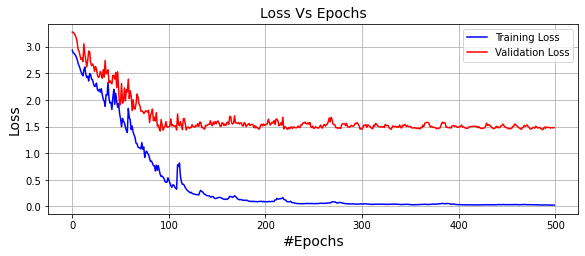

<Figure size 432x288 with 0 Axes>

In [56]:
create_loss_plot(obtained_train_loss_conv_gru_for,obtained_val_loss_conv_gru_for,'conv_gru_for_new',num_epochs=num_epochs,log_scale=False)

In [ ]:
create_loss_plot(obtained_train_loss_conv_gru_for,obtained_val_loss_conv_gru_for,'conv_gru_for_new',num_epochs=num_epochs,log_scale=False)

In [57]:
print(f"Best val loss ConvGRUForecaster : {min(obtained_val_loss_conv_gru_for)}")

Best val loss ConvGRUForecaster : 1.4169663190841675


## Evaluation

In [ ]:
def baseline_task32(tm1,tm2):
    return tm1 + (tm1 - tm2)

In [ ]:
## Baseline predictor eval
preds = []
val_running_loss = 0  
for test_data,test_targets in t2_test_loader:
    tm1 = test_data[:,:,-2:]
    tm2 = test_data[:,:,-4:-2]
    batch_preds = []
    # Give the baseline some advantage (it only predicts the guaranteed 2 seconds into the future) 
    # since it can't learn how to handle padded values
    for i in range(20):         
        pred = baseline_task32(tm1,tm2)
        tm2 = tm1
        tm1 = pred
        batch_preds.append(pred)
    pred = torch.stack(batch_preds,axis=1).squeeze(2).view(len(test_data),-1)
    loss = torch.mean((test_targets[:,:40] - pred)**2)
    print(f"Baseline predictor average batch loss: {loss}")
    val_running_loss += loss
    
print(f"Baseline predictor overall average loss: {val_running_loss/len(t2_test_loader)}")
    

    

Baseline predictor average batch loss: 3.163911819458008
Baseline predictor average batch loss: 2.7030704021453857
Baseline predictor average batch loss: 55.02543640136719
Baseline predictor average batch loss: 7.608280181884766
Baseline predictor average batch loss: 2.2458200454711914
Baseline predictor average batch loss: 3.5361969470977783
Baseline predictor average batch loss: 3.257389545440674
Baseline predictor average batch loss: 2.084474563598633
Baseline predictor average batch loss: 2.8502414226531982
Baseline predictor average batch loss: 2.2886922359466553
Baseline predictor overall average loss: 8.476350784301758


In [103]:
def evaluate_32(model, test_loader,device='cpu'):
    val_running_loss = 0.0
    preds = []
    actual = []
    input_list = []
    test_loss_list = []
    with torch.no_grad():
        model.eval()
        for val_data, val_targets in test_loader:
            input_tensor = val_data.to(device)
            input_list.append(input_tensor)
            outputs = model.forward(input_tensor)
            val_targets = torch.squeeze(val_targets, dim=1)
            preds.append(outputs)
            actual.append(val_targets)
            loss = criterion(outputs,val_targets.to(device))
            val_running_loss += loss
            test_loss_list.append(loss)

        avg_val_loss = val_running_loss / len(test_loader)
        print("Average Test Loss: {:4f}".format(avg_val_loss))
        return preds,actual, input_list, test_loss_list

In [104]:
#Model Evaluation
#ConvGRUForecaster
model = ConvGRUForecaster(input_dim=220,hidden_dim=512,output_dim=2,device='cpu')
checkpoint = torch.load('conv_GRU_for_500.pt', map_location = 'cpu')
model.load_state_dict(checkpoint['model_dict'])

preds,actual,inputs, test_loss = evaluate_32(model, t2_test_loader)

Average Test Loss: 1.382536


In [105]:
def conv_tens(inp_arr, batch_size, sequence_len, dim):
  conv_array = []
  for i in inp_arr:
    conv = i.reshape(batch_size, sequence_len, dim)
    conv_array.append(conv)
  return conv_array

conv_pred = conv_tens(preds, 10,60,2)
conv_targets = conv_tens(actual, 10,60,2)
conv_input = conv_tens(inputs, 10,110,2)

Predicted Continued Simulation



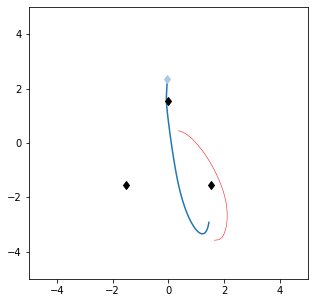


Actual Continued Simulation



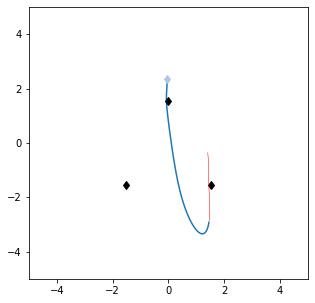

Charges are [-0.48912768 -0.53956225 -0.53497113]


In [106]:
#Plot the functions 
batch_idx = np.random.randint(0,9) 
test_idx = np.random.randint(0,9)
print(f'Predicted Continued Simulation\n')
plot_example(conv_input[batch_idx][test_idx],conv_pred[batch_idx][test_idx])
print(f'\nActual Continued Simulation\n')
plot_example(conv_input[batch_idx][test_idx],conv_targets[batch_idx][test_idx])
print(f'Charges are {charges_train[test_idx]}')

In [107]:
best_batch = np.argmin(test_loss)
worst_batch = np.argmax(test_loss)

print(f"The batch with the best test loss is {best_batch}")
print(f"The batch with the worst test loss is {worst_batch}")

The batch with the best test loss is 7
The batch with the worst test loss is 2



Best Case 0

Test loss for the best batch 7 is 0.8025960326194763

Predicted Continued Simulation



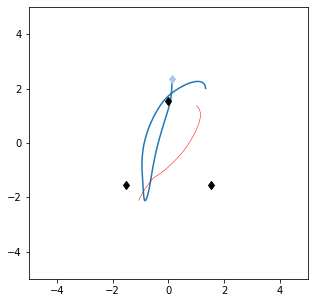


Actual Continued Simulation



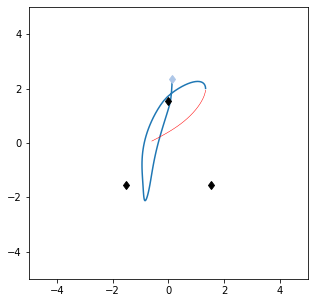


Best Case 1

Test loss for the best batch 7 is 0.8025960326194763

Predicted Continued Simulation



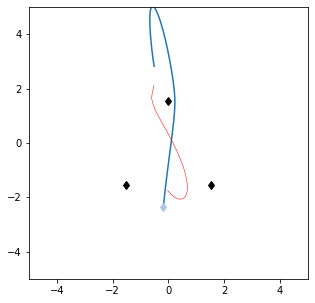


Actual Continued Simulation



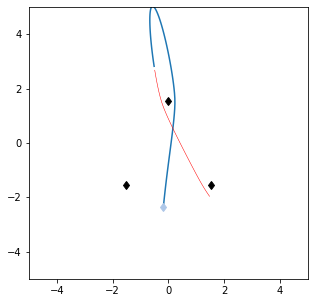


Best Case 2

Test loss for the best batch 7 is 0.8025960326194763

Predicted Continued Simulation



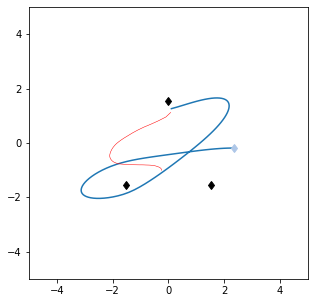


Actual Continued Simulation



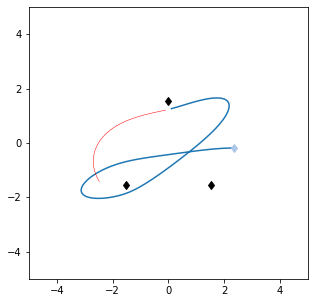


Best Case 3

Test loss for the best batch 7 is 0.8025960326194763

Predicted Continued Simulation



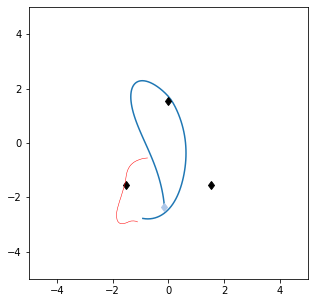


Actual Continued Simulation



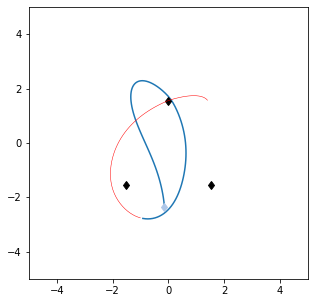


Best Case 4

Test loss for the best batch 7 is 0.8025960326194763

Predicted Continued Simulation



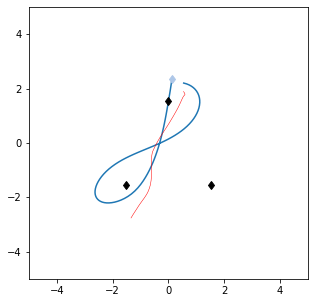


Actual Continued Simulation



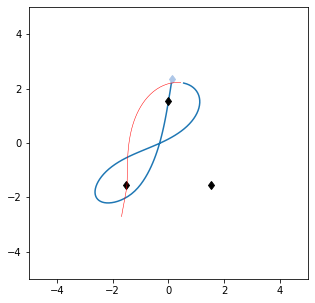


Best Case 5

Test loss for the best batch 7 is 0.8025960326194763

Predicted Continued Simulation



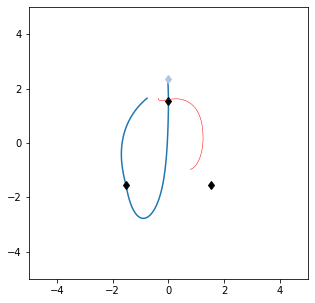


Actual Continued Simulation



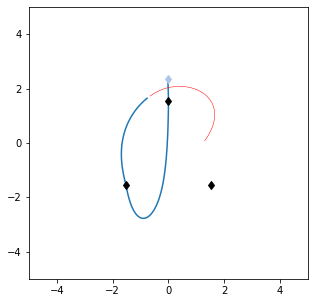


Best Case 6

Test loss for the best batch 7 is 0.8025960326194763

Predicted Continued Simulation



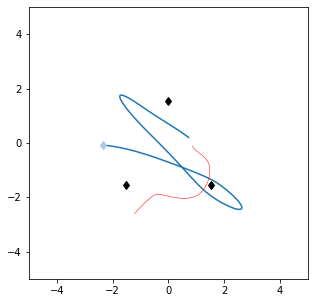


Actual Continued Simulation



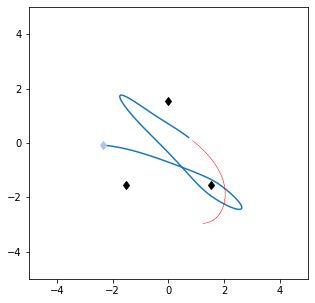


Best Case 7

Test loss for the best batch 7 is 0.8025960326194763

Predicted Continued Simulation



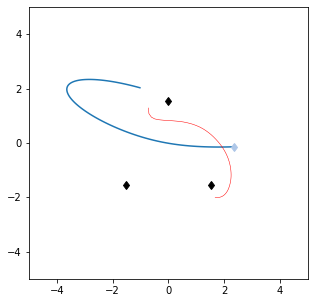


Actual Continued Simulation



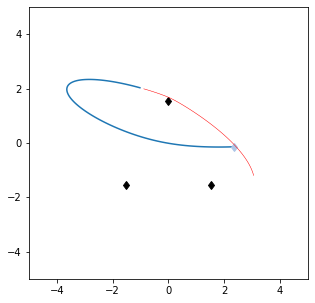


Best Case 8

Test loss for the best batch 7 is 0.8025960326194763

Predicted Continued Simulation



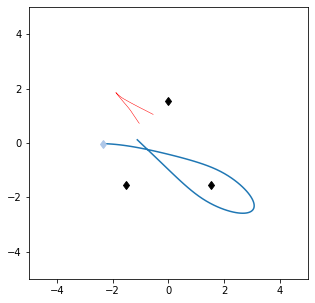


Actual Continued Simulation



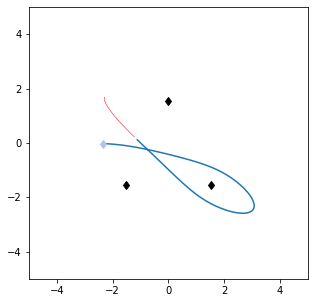


Best Case 9

Test loss for the best batch 7 is 0.8025960326194763

Predicted Continued Simulation



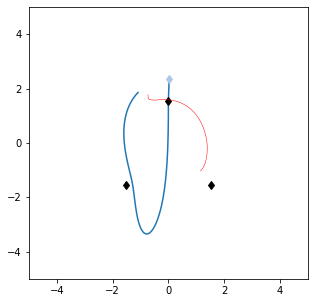


Actual Continued Simulation



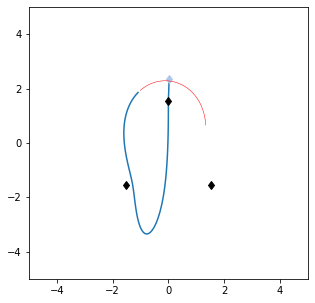

In [113]:
#Evaluating Individual Cases
#best prediction 
best_preds = conv_pred[best_batch]
best_targets = conv_targets[best_batch]
worst_preds = conv_pred[worst_batch]
worst_targets = conv_targets[worst_batch]

#Plotting the best cases.
for best_test_idx in range(0,10):
  print(f"\nBest Case {best_test_idx}\n")
  print(f'Test loss for the best batch {best_batch} is {test_loss[best_batch]}')
  print(f'\nPredicted Continued Simulation\n')
  plot_example(conv_input[best_batch][best_test_idx], conv_pred[best_batch][best_test_idx])
  print(f'\nActual Continued Simulation\n')
  plot_example(conv_input[best_batch][best_test_idx], conv_targets[best_batch][best_test_idx])



Worst Case 0 

Test loss for the worst batch 2 is 2.0330111980438232

Predicted Continued Simulation



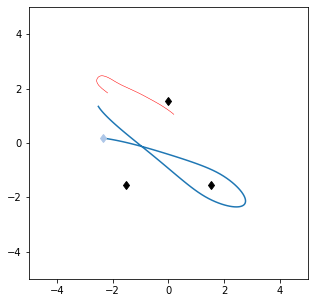


Actual Continued Simulation



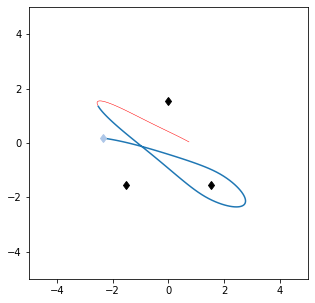


Worst Case 1 

Test loss for the worst batch 2 is 2.0330111980438232

Predicted Continued Simulation



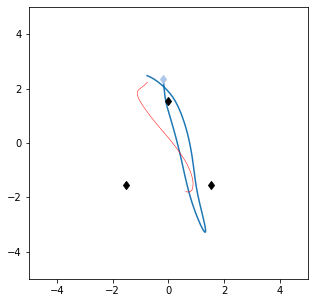


Actual Continued Simulation



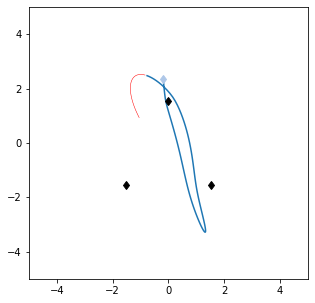


Worst Case 2 

Test loss for the worst batch 2 is 2.0330111980438232

Predicted Continued Simulation



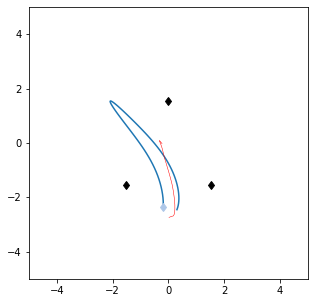


Actual Continued Simulation



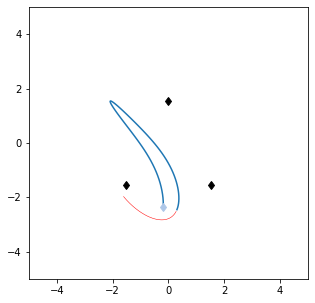


Worst Case 3 

Test loss for the worst batch 2 is 2.0330111980438232

Predicted Continued Simulation



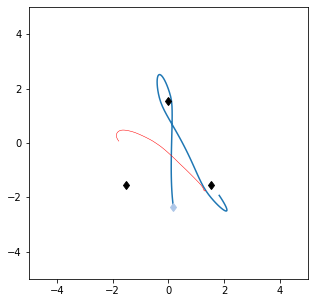


Actual Continued Simulation



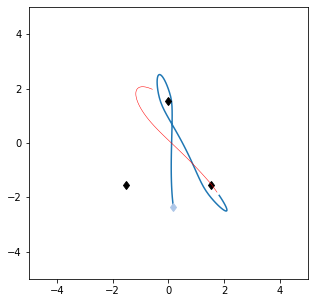


Worst Case 4 

Test loss for the worst batch 2 is 2.0330111980438232

Predicted Continued Simulation



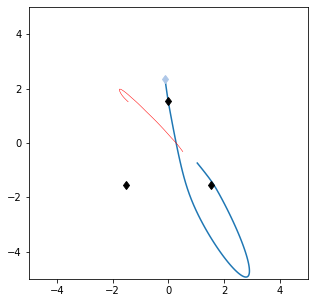


Actual Continued Simulation



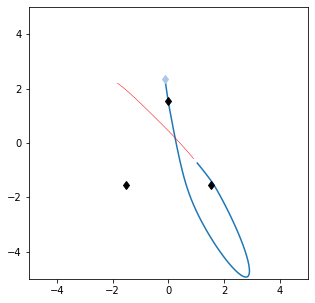


Worst Case 5 

Test loss for the worst batch 2 is 2.0330111980438232

Predicted Continued Simulation



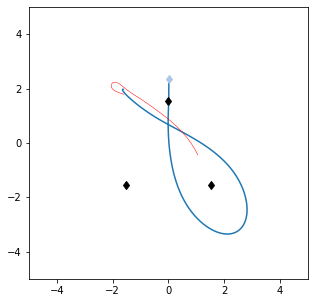


Actual Continued Simulation



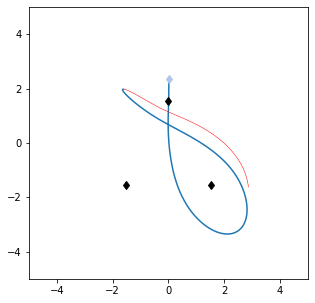


Worst Case 6 

Test loss for the worst batch 2 is 2.0330111980438232

Predicted Continued Simulation



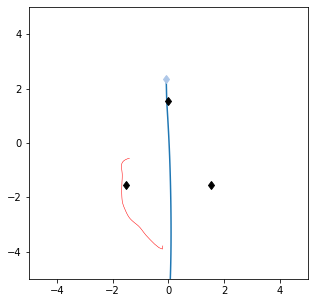


Actual Continued Simulation



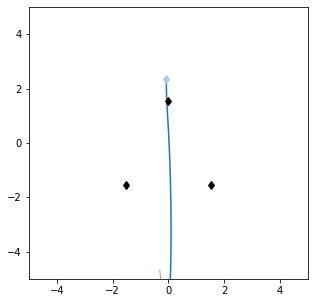


Worst Case 7 

Test loss for the worst batch 2 is 2.0330111980438232

Predicted Continued Simulation



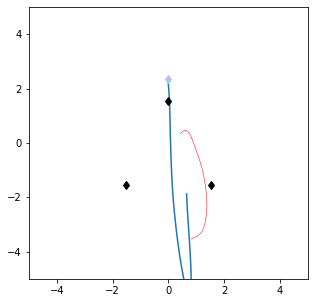


Actual Continued Simulation



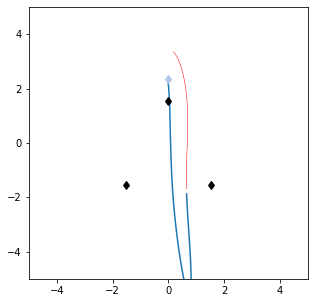


Worst Case 8 

Test loss for the worst batch 2 is 2.0330111980438232

Predicted Continued Simulation



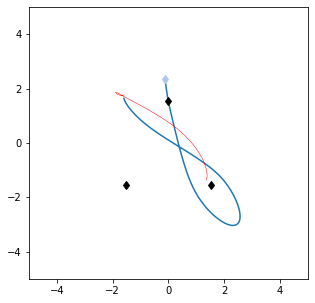


Actual Continued Simulation



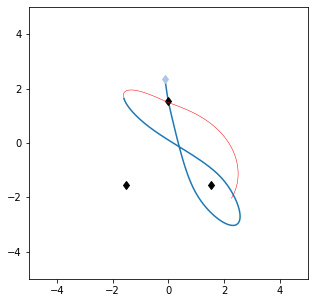


Worst Case 9 

Test loss for the worst batch 2 is 2.0330111980438232

Predicted Continued Simulation



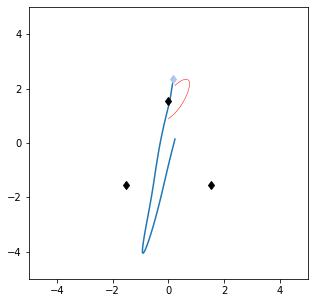


Actual Continued Simulation



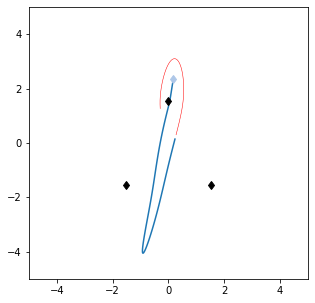

In [114]:
for worst_test_idx in range(0,10):
  print(f"\nWorst Case {worst_test_idx} \n")
  print(f'Test loss for the worst batch {worst_batch} is {test_loss[worst_batch]}')
  print(f'\nPredicted Continued Simulation\n')
  plot_example(conv_input[worst_batch][worst_test_idx],conv_pred[worst_batch][worst_test_idx])
  print(f'\nActual Continued Simulation\n')
  plot_example(conv_input[worst_batch][worst_test_idx],conv_targets[worst_batch][worst_test_idx])
